# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

In [1]:
!pip install --upgrade scikit-learn

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [3]:
df=pd.read_csv('/datasets/users_behavior.csv')
df_x=df.drop('is_ultra',axis=1)
df_y=df['is_ultra']
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


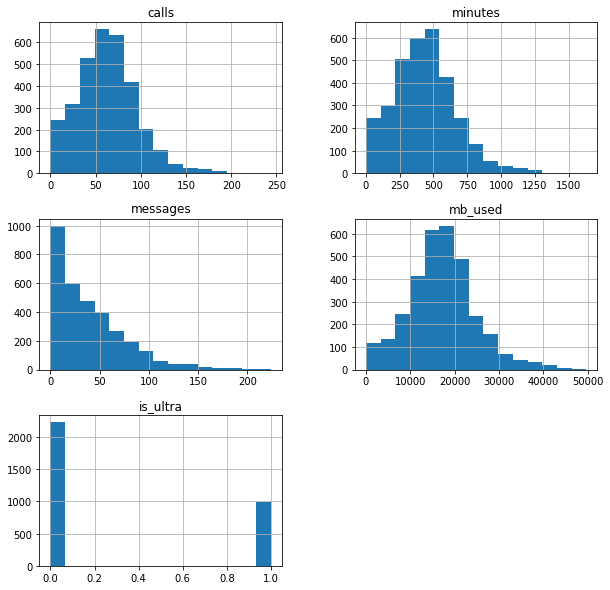

In [5]:
df.hist(bins=15,figsize=(10,10));

In [6]:
df.corr()

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


In [7]:
df=df.drop('calls',axis=1)

## Разбейте данные на выборки

Необходимо разбить ДФ на 3 выборки Тренировочную, Тестовую и Валидационную. Буду делить 60:20:20

In [8]:
df_train, df_test1 =train_test_split(df, test_size=0.4, random_state=42) #40% DF для теста и валидации
df_test, df_val=train_test_split(df_test1, test_size=0.5, random_state=42) #50на 50 те 40% для теста и валидации

In [9]:
#Фичи и лейблы для трейна
X_train=df_train.drop('is_ultra',axis=1)
y_train=df_train['is_ultra']

#Фичи и лейблы для testa
X_test=df_test.drop('is_ultra',axis=1)
y_test=df_test['is_ultra']

#Фичи и лейблы для валидации
X_valid=df_val.drop('is_ultra',axis=1)
y_valid=df_val['is_ultra']

print(X_train.shape,X_test.shape,X_valid.shape)
print((X_train.shape[0]/X_test.shape[0]),':',X_test.shape[0]/X_test.shape[0],':',X_test.shape[0]/X_test.shape[0])

(1928, 3) (643, 3) (643, 3)
2.998444790046656 : 1.0 : 1.0


## Исследуйте модели

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error

from sklearn.metrics import roc_auc_score,precision_score,recall_score,classification_report

from catboost import CatBoostClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import RocCurveDisplay
from sklearn.svm import SVC

from sklearn.dummy import DummyClassifier

In [11]:
scaler = StandardScaler()
scaler.fit(X_train) 

X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [12]:
models=[RandomForestClassifier,DecisionTreeClassifier,LogisticRegression]
models_gyper=[RandomForestClassifier,DecisionTreeClassifier]
#Наши исследуемые модели

parameters={'n_estimators':[50,100,150],
            'max_depth':[1,2],
            'min_samples_split':[2,3],
            'min_samples_leaf':[1,2],
           }


for i in np.arange(3,0,-1):
    for j in np.arange(1,3,1):
        for k in np.arange(3,0,-1):
            x=RandomForestClassifier(max_depth=i,min_samples_leaf=j,n_estimators=k)
            
for i in np.arange(3,0,-1):
    for j in np.arange(2,3,1):
        for k in np.arange(10,160,10):
            x=DecisionTreeClassifier(max_depth=i,min_samples_split=j,min_samples_leaf=k)


In [13]:
valid_acc=0
roc_auc_valid=0
for i in np.arange(3,0,-1):
    for j in np.arange(1,3,1):
        for k in np.arange(10,160,10):
            model_test=RandomForestClassifier(max_depth=i,min_samples_leaf=j,n_estimators=k,random_state=1861)
            model_test.fit(X_train,y_train)
            pred=model_test.predict(X_valid)
            acc=accuracy_score(y_valid, pred)
            roc=roc_auc_score(y_valid, model_test.predict_proba(X_valid)[:,-1])
            if acc>valid_acc:
                valid_acc=acc
                valid_mod_RF=model_test
                roc_auc_valid=roc
            
print('RandomForestClassifier','имеет accuracy=',valid_acc,'roc_auc=',roc_auc_valid)
valid_acc=0
roc_auc_valid=0
for i in np.arange(3,0,-1):
    for j in np.arange(2,3,1):
        for k in np.arange(3,0,-1):
            
            model_test=DecisionTreeClassifier(max_depth=i,min_samples_split=j,min_samples_leaf=k,random_state=1861)
            
            model_test.fit(X_train,y_train)
            pred=model_test.predict(X_valid)
            acc=accuracy_score(y_valid, pred)
            roc=roc_auc_score(y_valid, model_test.predict_proba(X_valid)[:,-1])
            if acc>valid_acc:
                valid_acc=acc
                valid_mod_DT=model_test
                roc_auc_valid=roc
            
print('DecisionTreeClassifier','имеет accuracy=',valid_acc,'roc_auc=',roc_auc_valid)

valid_acc=0
roc_auc_valid=0
model_test=LogisticRegression(random_state=1861).fit(X_train,y_train)
pred=model_test.predict(X_valid)
acc=accuracy_score(y_valid, pred)
roc=roc_auc_score(y_valid, model_test.predict_proba(X_valid)[:,-1])

if acc>valid_acc:
    valid_acc=acc
    valid_mod_LR=model_test
    roc_auc_valid=roc

print('LogisticRegression','имеет accuracy=',valid_acc,'roc_auc=',roc_auc_valid)

RandomForestClassifier имеет accuracy= 0.8102643856920684 roc_auc= 0.7998798076923077
DecisionTreeClassifier имеет accuracy= 0.8055987558320373 roc_auc= 0.7245135073260074
LogisticRegression имеет accuracy= 0.7698289269051322 roc_auc= 0.6814331501831502


Выполню сравнение с Baseline моделью.

In [14]:
dmm=DummyClassifier(strategy='most_frequent', random_state=700).fit(X_train,y_train)
pred_dmm=dmm.predict(X_valid)
acc_dmm=accuracy_score(y_valid, pred_dmm)
roc_dmm=roc_auc_score(y_valid, dmm.predict_proba(X_valid)[:,-1])
print("accuracy",acc_dmm,"roc_auc",roc_dmm)

accuracy 0.6967340590979783 roc_auc 0.5


Данная модель значительно хуже выбранных мной для анализа, значит можно двигаться дальше.

In [15]:
pred=valid_mod_RF.predict(X_valid)
acc=accuracy_score(y_valid, pred)
roc=roc_auc_score(y_valid, valid_mod_RF.predict_proba(X_valid)[:,-1])
print(valid_mod_RF,acc,roc,'Сохраню лучшую тестовую модель')

RandomForestClassifier(max_depth=3, n_estimators=10, random_state=1861) 0.8102643856920684 0.7998798076923077 Сохраню лучшую тестовую модель


Как видим, модель RandomForestClassifier справляется лучше всего. Далее работать буду с ней.

Вывод: 

По следующему выводу:

RandomForestClassifier имеет accuracy= 0.8102643856920684 roc_auc= 0.7998798076923077
DecisionTreeClassifier имеет accuracy= 0.8055987558320373 roc_auc= 0.7245135073260074
LogisticRegression имеет accuracy= 0.7698289269051322 roc_auc= 0.6814331501831502

можно сказать, что ЛогРегрессия показала себя хуже всего. Рандомный лес по accuracy на 0.5% лучше

Проведу улучшение модели с помощью кроссвалидации. Это позволит нивелировать возможную перетренированность.

Разделю выборку на трейн и тест как 80к20 для обучения GridSearchCV

In [16]:
model_work=RandomForestClassifier(random_state=1861)

df_train_cross, df_test_cross =train_test_split(df, test_size=0.2, random_state=42)

X_cross=df_train_cross.drop('is_ultra',axis=1)
y_cross=df_train_cross['is_ultra']
X_cross.shape

(2571, 3)

In [17]:
'''parameters={'n_estimators':np.arange(500,520,10),
            'max_depth':np.arange(8,11,1),
            'min_samples_split':[3],
            'min_samples_leaf':[1],
           }

search = GridSearchCV(model_work, parameters, n_jobs=-1, cv=5, refit=True, scoring='accuracy',error_score='raise',verbose=True)
# запустим поиск
search.fit(X_cross, y_cross)

# выведем наилучшие параметры
print(search.best_params_)'''
'''
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 500}
'''


"\n{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 500}\n"

In [18]:
model_work_cross3=RandomForestClassifier(max_depth=10,
                                        min_samples_leaf=1,min_samples_split=3,
                                        n_estimators=500,random_state=1861)
model_work_cross3.fit(X_train,y_train)

print('Валидация',accuracy_score(y_valid, model_work_cross3.predict(X_valid)))

Валидация 0.8180404354587869


По анализу из кросс-валидации были получены лучшие параметры для данной модели 

{'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 500}

Я выбрал лучшую модель, и улучшил ее на кросс-валидации. Это RandomForestClassifier
со значением accuracy на валидации 0.818

## Проверьте модель на тестовой выборке

In [19]:
test_mod=model_work_cross3#RandomForestClassifier

y_pred_test=test_mod.predict(X_test)
acc_test=accuracy_score(y_test, y_pred_test)
print('Модель RandomForestClassifier имеет accuracy на тестовой выборке:',acc_test,",на валидационной:",acc)


Модель RandomForestClassifier имеет accuracy на тестовой выборке: 0.807153965785381 ,на валидационной: 0.8102643856920684


Похоже что есть некоторое переобучение модели, попробую провести кроссвалидацию. Возможно это нормальное явление такого снижения качества

Вывод: После итерационной кросс-валидации я получил модель с весьма хорошими параметрами

Валидация 0.818
Тест 0.807


## (бонус) Проверьте модели на адекватность

Для проверки адекватности модели я буду использовать следующие метрики: roc_auc_score,precision_score,recall_score,classification_report

roc_auc показывает отношение TruePositive ответов к FalsePositive, то есть как модель угадывает верные ответы к выдаче предсказаний по ложной классификаци.


Recall показывает полноту, отношение TruePositive как разнице TP-FN: tp / (tp + fp)


Precision показывае tp / (tp + fp), сколько TruePositive из всех предсказаний


Precision можно интерпретировать как долю объектов, названных классификатором положительными и при этом действительно являющимися положительными, а recall показывает, какую долю объектов положительного класса из всех объектов положительного класса нашел алгоритм.

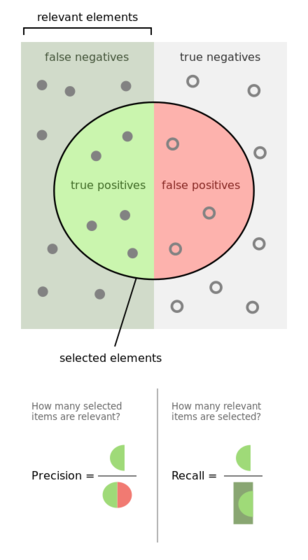
#https://habr.com/ru/company/ods/blog/328372/

In [20]:
print('roc_auc_score:',roc_auc_score(y_test, model_work_cross3.predict_proba(X_test)[:,-1]),
      'precision_score:',precision_score(y_test, model_work_cross3.predict(X_test)),
     'recall_score:',recall_score(y_test, model_work_cross3.predict(X_test)))



roc_auc_score: 0.8273314971204844 precision_score: 0.7874015748031497 recall_score: 0.5076142131979695


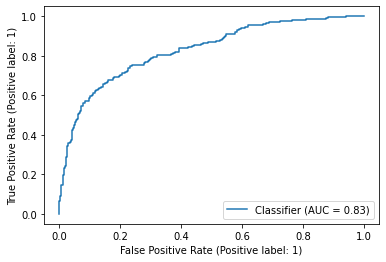

In [21]:

RocCurveDisplay.from_predictions(y_test, model_work_cross3.predict_proba(X_test)[:,-1])
plt.show()

In [22]:
print(classification_report(y_test,model_work_cross3.predict(X_test),target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.81      0.94      0.87       446
           1       0.79      0.51      0.62       197

    accuracy                           0.81       643
   macro avg       0.80      0.72      0.74       643
weighted avg       0.80      0.81      0.79       643



In [23]:
import warnings
warnings.filterwarnings('ignore')
print(classification_report(y_test,dmm.predict(X_test),target_names=['0','1']))
print('accuracy от DummyClassifier',accuracy_score(y_test,dmm.predict(X_test)))


              precision    recall  f1-score   support

           0       0.69      1.00      0.82       446
           1       0.00      0.00      0.00       197

    accuracy                           0.69       643
   macro avg       0.35      0.50      0.41       643
weighted avg       0.48      0.69      0.57       643

accuracy от DummyClassifier 0.6936236391912908


В целом можно сказать, что модель адекватная, roc-auc=0.72, precision_score: 0.79. 

Меня смущает метрика Recall=0.51, если я правильно понимаю, то модель правильно определяет 51% целевых переменных. А остальные получается ложно отрицательные.

Так же сравнение рабочей модели с элементарной DummyClassifier, показывает серьезный выйгрыш у рабочей модели, что говорит о ее адекватности.

Еще попробую кое-что)

In [25]:
model_cat = CatBoostClassifier(iterations=100,learning_rate=0.1,
                         depth=12,verbose=False)

model_cat.fit(X_train,y_train)
preds_cat= model_cat.predict(X_valid)
acc_cat=accuracy_score(y_valid, preds_cat)
acc_cat

0.8164852255054432

In [26]:

preds_cat= model_cat.predict(X_test)

print(
      'precision_score:',precision_score(y_test, preds_cat),
     'recall_score:',recall_score(y_test, preds_cat))

precision_score: 0.7819548872180451 recall_score: 0.5279187817258884


Модель с градиентным бустингом CatBoostClassifier показала примерно такой же accuracy, но по другим метрикам она вышла менее адекватная чем Случайный Лес.

## Вывод:
По выполнению проекта, была создана оптимизированная модель случайного леса, которая имеет:

Валидация accuracy= 0.818 Тест accuracy= 0.807

По условию задания удалось достичь accuracy не меньше 0.75, а по анализу адекватности первая модель показывает лучшие значения.

Так же дополнительно была оценена модель с градиентным бустингом CatBoostClassifier, которая показала примерно такой же accuracy, но по другим метрикам она вышла менее адекватная чем Случайный Лес.